# Capstone Project: Udacity Machine Learning Engineer
## Hans Fricke 2018
## Unsupervised learning, text data aggregation, topic modelling

In [1]:
# import packages
import pandas as pd
import os
import numpy as np
import random
from scipy import sparse
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
# display formatting
%matplotlib inline 
pd.options.display.float_format = '{:20,.2f}'.format

# change working directory
os.chdir("/Users/hansfricke/Dropbox/ND ML Engineer/Capstone")

In [3]:
proposals = pd.read_pickle('Data/pre_cleaned_proposals.pkl')

### Functions to prep text data and model topics

##### Tfidf vectorization

In [4]:
def tfidf_vectorize(text, no_features):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features)
    tfidf = tfidf_vectorizer.fit_transform(text)
    feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf, feature_names

##### Non-negative matrix factorization transformation

In [5]:
def topic_modeling_trans(word_array, no_topics):
    nmf = NMF(n_components=no_topics, 
              random_state=1, 
              alpha=.1, 
              l1_ratio=.5, 
              init='nndsvd').fit_transform(word_array)
    return nmf

##### Non-negative matrix factorization fit only

In [6]:
def topic_modeling(word_array, no_topics):
    nmf = NMF(n_components=no_topics, 
              random_state=1, 
              alpha=.1, 
              l1_ratio=.5, 
              init='nndsvd').fit(word_array)
    return nmf

### Functions to determine optimal number of topics with Calinski-Harabaz Index

##### Function to get optimal score (Calinski-Harabaz Index) for a given number of topics

In [7]:
def get_score(X, n_topics):
    nmf = topic_modeling_trans(X, n_topics)
    labels = np.argmax(nmf, axis=1)
    return metrics.calinski_harabaz_score(X.todense(), labels)

##### Get scores for a range of topic numbers

In [8]:
def scores_n_topics(X, topic_range):
    start = topic_range[0]
    end = topic_range[1]
    scores = {n:get_score(X, n) for n in topic_range}
    return scores

##### Function to plot scores according for each number of topics

In [9]:
def plot_scores(scores, path, name):
    lists = sorted(scores.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.plot(x,y)
    plt.axvline(x[np.argmax(y)], color='red')
    plt.xlabel('Number of topics')
    plt.ylabel('Calinski-Harabaz Index')
    plt.title(name)
    save_as = path + "/" + name + ".png"
    plt.savefig(save_as)
    plt.show()

##### Function to get number of topic with highest score

In [10]:
def get_max_n(scores):
    lists = sorted(scores.items())
    topics, scs = zip(*lists)
    return  topics[np.argmax(scs)]

### Fuction to diplay top words per topic

In [11]:
def create_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_name = "Topic" + str(topic_idx)
        topics[topic_name] = [feature_names[i] for i in 
                               topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topics) 

### Fuction to add components to data

In [12]:
def join_topics_to_data(model, word_array, dataframe, prefix ):
    no_topics = len(model.components_)
    new_column_names = [prefix + 'Topic' + str(n) for n in range(0, no_topics)]
    dataframe[new_column_names] = pd.DataFrame(model.transform(word_array))
    return dataframe

### Apply all that to all text columns

In [13]:
text_cols = ['c_essay1', 'c_essay2', 'c_resource_summary', 'c_total_description']

##### Tfidf factorization

In [14]:
tfidf = {}
for text_col in text_cols:
    tfidf_matrix, features = tfidf_vectorize(proposals[text_col], 1000)
    tfidf[text_col] = {'tfidf': tfidf_matrix, 
                        'features': features}

##### Optimal number of topic

In [15]:
scores = {}
for text_col in text_cols:
    scores[text_col] = scores_n_topics(tfidf[text_col]['tfidf'], range(2,16))

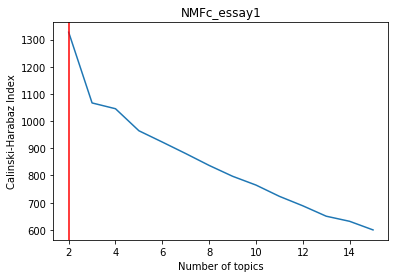

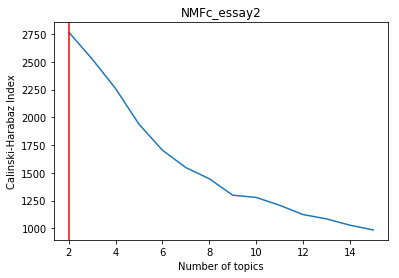

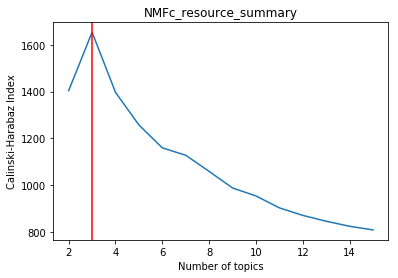

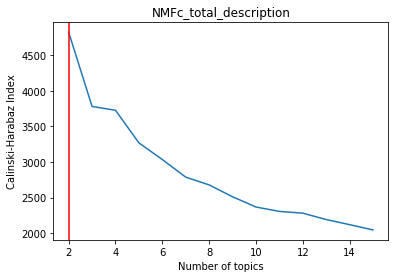

In [16]:
for text_col in text_cols:
    name = 'NMF' + text_col
    plot_scores(scores[text_col], './Graphs', name)

In [17]:
optimal_n_topics = {}
for text_col in text_cols:
    optimal_n_topics[text_col] = get_max_n(scores[text_col])

##### Fit nmf with optimal number of topics

In [18]:
nmfs_optimal = {}
for text_col in text_cols:
    nmfs_optimal[text_col] = topic_modeling(tfidf[text_col]['tfidf'], optimal_n_topics[text_col])

##### Show top words in each topic

In [19]:
for text_col in text_cols:
    print('----', text_col, '----')
    print(create_topics(nmfs_optimal[text_col], tfidf[text_col]['features'], 10))

---- c_essay1 ----
       Topic0   Topic1
0       learn   school
1   classroom     come
2        love     many
3        work     free
4        need    lunch
5       class     home
6  technology  receive
7     reading   family
8         new     face
9       grade     high
---- c_essay2 ----
       Topic0     Topic1
0       learn       book
1         use    reading
2   classroom       read
3        help    library
4        work      level
5        need     chrome
6  technology       love
7       allow       text
8        able  classroom
9       would      story
---- c_resource_summary ----
      Topic0     Topic1      Topic2
0       book    seating       learn
1     chrome   flexible          ma
2    reading      chair        help
3       read     option  technology
4      level     wobble    material
5  classroom      stool       skill
6    library  classroom         use
7        set      learn      supply
8   interest      focus   classroom
9     access      balls        hand
---- c_to

##### Join topic columns to dataframe

In [20]:
nmf_topics = pd.DataFrame(proposals['id'])
for text_col in text_cols:
    nmf_topics = join_topics_to_data(nmfs_optimal[text_col], tfidf[text_col]['tfidf'], nmf_topics, text_col)

##### Display top documants for each topic

In [21]:
nmf_topics.to_pickle('Data/nmf_topics.pkl')